### YOLO v8 train & inference

We use the YOLO V8 model for this competition because it can execute the object detection and segmentation at the same time.  
Because of this notebook is online, we can't submit this directly.  

In [1]:
import shutil
import os
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

from pathlib import Path
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image as show_image

import ultralytics
from ultralytics import YOLO

import torch

ultralytics.checks()

Ultralytics YOLOv8.0.131 🚀 Python-3.9.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
Setup complete ✅ (24 CPUs, 31.1 GB RAM, 1479.9/1832.2 GB disk)


## Set parameters

### Hyper parameters

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMAGE_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 200

# File path settings
# BASE_DIR = Path('/kaggle/input/hubmap-hacking-the-human-vasculature')
BASE_DIR = Path('/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data')

print(device)

cuda


### Directories

In [3]:
def mkdir_yolo_data(train_path, val_path):
    """
    make yolo data's directories
    
    parameters
    ----------
    train_path: str
        path for training data
    val_path: str
        path for validation data
    
    returns
    ----------
    train_image_path: str
        path for images of training data
    train_label_path: str
        path for labels of trainingdata
    val_image_path: str
        path for images of validation data
    val_label_path: str
        path for labels of validation data
    """
    train_image_path = Path(f'{train_path}/images')
    train_label_path = Path(f'{train_path}/labels')
    val_image_path = Path(f'{val_path}/images')
    val_label_path = Path(f'{val_path}/labels')
    
    train_image_path.mkdir(parents=True, exist_ok=True)
    train_label_path.mkdir(parents=True, exist_ok=True)
    val_image_path.mkdir(parents=True, exist_ok=True)
    val_label_path.mkdir(parents=True, exist_ok=True)
    
    return train_image_path, train_label_path, val_image_path, val_label_path

In [4]:


test_paths = glob(f'{BASE_DIR}/test/*')
polygons_path = f'{BASE_DIR}/polygons.jsonl'

yolo_train_path = 'datasets/train'
yolo_val_path = 'datasets/val'

In [5]:
# make directories
train_image_path, train_label_path, val_image_path, val_label_path = mkdir_yolo_data(yolo_train_path, yolo_val_path)
print(train_image_path)
print(train_label_path)
print(val_image_path)
print(val_label_path)

datasets/train/images
datasets/train/labels
datasets/val/images
datasets/val/labels


In [6]:
import torch


state_dict = torch.load("/home/viktor/Documents/kaggle/hubmap-2023/experiments/yolo/yolov8-vanilla/YOLOv8x-seg/runs/segment/train/weights/best.pt")

state_dict;

In [7]:
# state_dict['model'].__dict__

## Create annotation files and move tif to yolo' directory

In [8]:
def create_vessel_annotations(polygons_path):
    """
    Create annotations set which have blood_vessel label.
    
    parameters
    ----------
    polygons_path: str
        path of polygons.jsonl
    
    returns
    ----------
    annotations_dict: dict {key=id, value=coordinates}
        annotations dict with key id and value coordinates of blood_vessel
    """
    # load polygons data
    polygons = pd.read_json(polygons_path, orient='records', lines=True)
    
    # extract blood_vessel annotation
    annotations_dict = defaultdict(list)
    for idx, row in polygons.iterrows():
        id_ = row['id']
        annotations = row['annotations']
        for annotation in annotations:
            if annotation['type'] == 'blood_vessel':
                annotations_dict[id_].append(annotation['coordinates'])
    
    return annotations_dict

def create_label_file(id_, coordinates, path):
    """
    Create label txt file for yolo v8
    
    parameters
    ----------
    id_: str
        label id
    coordinates: list
        coordinates of blood_vessel
    path: str
        path for saving label txt file
    """
    label_txt = ''
    for coordinate in coordinates:
        label_txt += '0 '
        # Normalize
        coor_array = np.array(coordinate[0]).astype(float)
        coor_array /= float(IMAGE_SIZE)
        # transform to str
        coor_list = list(coor_array.reshape(-1).astype(str))
        coor_str = ' '.join(coor_list)
        # add string to label txt
        label_txt += f'{coor_str}\n'
    
    # Write labels to txt file
    with open(f'{path}/{id_}.txt', 'w') as f:
        f.write(label_txt)
        
def prepare_yolo_dataset(
        annotaions_dict, train_image_path, train_label_path, 
        val_image_path, val_label_path):
    """
    Prepare yolo dataset with images and labels
    
    parameters
    ----------
    annotations_dict: dict {key=id, value=coordinates}
        annotations dict with key id and value coordinates of blood_vessel
    train_image_path: str
        path for images of training data
    train_label_path: str
        path for labels of trainingdata
    val_image_path: str
        path for images of validation data
    val_label_path: str
        path for labels of validation data
    """
    ids = list(annotations_dict.keys())
    
    # train test split
    indices = [i for i in range(len(ids))]
    train_indices, val_indices = train_test_split(indices, test_size=0.02, random_state=1234)
    
    # Training data
    for index in tqdm(train_indices):
        id_ = ids[index]
        
        # create label txt file
        create_label_file(id_, annotations_dict[id_], train_label_path)
        # copy tif image file to yolo directory
        source_file = f'{BASE_DIR}/train/{id_}.tif'
        shutil.copy2(source_file, train_image_path)
    
    # Validation data
    for index in tqdm(val_indices):
        id_ = ids[index]
        
        # create label txt file
        create_label_file(id_, annotations_dict[id_], val_label_path)
        # copy tif image file to yolo directory
        source_file = f'{BASE_DIR}/train/{id_}.tif'
        shutil.copy2(source_file, val_image_path)
    

In [9]:
# Create annotations dict with key=id and value=coordinates
annotations_dict = create_vessel_annotations(polygons_path)

In [10]:
# Prepare dataset for yolo training
prepare_yolo_dataset(
    annotations_dict, train_image_path, train_label_path,
    val_image_path, val_label_path
)

100%|██████████| 33/33 [00:00<00:00, 868.54it/s]


## YOLO

In [11]:
# Edit yaml content
yaml_content = f'''
train: train/images
val: val/images

names:
    0: blood_vessel
'''

yaml_file = 'data.yaml'

with open(yaml_file, 'w') as f:
    f.write(yaml_content)

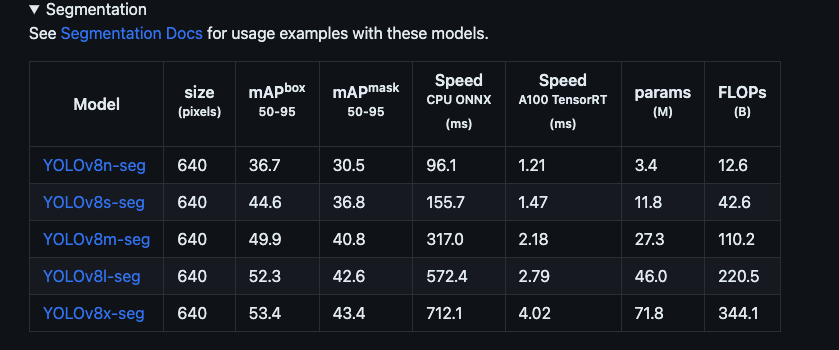

In [12]:
# prepare model
model = YOLO('yolov8x-seg.pt')
# model = YOLO('yolov8x.pt')
# model = YOLO("/home/viktor/Documents/kaggle/hubmap-2023/experiments/yolo/yolov8-vanilla/YOLOv8x-seg/runs/segment/train/weights/best.pt")

In [13]:
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))
pred = model.predict(x)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 4.7241740226745605. Dividing input by 255.
0: 512x512 (no detections), 63.4ms
Speed: 0.4ms preprocess, 63.4ms inference, 0.2ms postprocess per image at shape (1, 3, 512, 512)


In [14]:
# training
results = model.train(
    batch=BATCH_SIZE,
    device=0,
    data=yaml_file,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    mixup=0.2,
    mosaic=0.2,
    flipud=0.2,
    shear=0.2,
    degrees=45,
    copy_paste=0.2,
    dropout=0.2,
    iou=0.7,
    mask_ratio=2,
    seed=42,
    
)

New https://pypi.org/project/ultralytics/8.0.132 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.131 🚀 Python-3.9.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=data.yaml, epochs=40, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=2, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

In [15]:
!ls runs/segment/train

args.yaml			 MaskP_curve.png      train_batch2.jpg
BoxF1_curve.png			 MaskPR_curve.png     val_batch0_labels.jpg
BoxP_curve.png			 MaskR_curve.png      val_batch0_pred.jpg
BoxPR_curve.png			 results.csv	      val_batch1_labels.jpg
BoxR_curve.png			 results.png	      val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch0.jpg     val_batch2_labels.jpg
confusion_matrix.png		 train_batch1.jpg     val_batch2_pred.jpg
labels_correlogram.jpg		 train_batch2460.jpg  weights
labels.jpg			 train_batch2461.jpg
MaskF1_curve.png		 train_batch2462.jpg


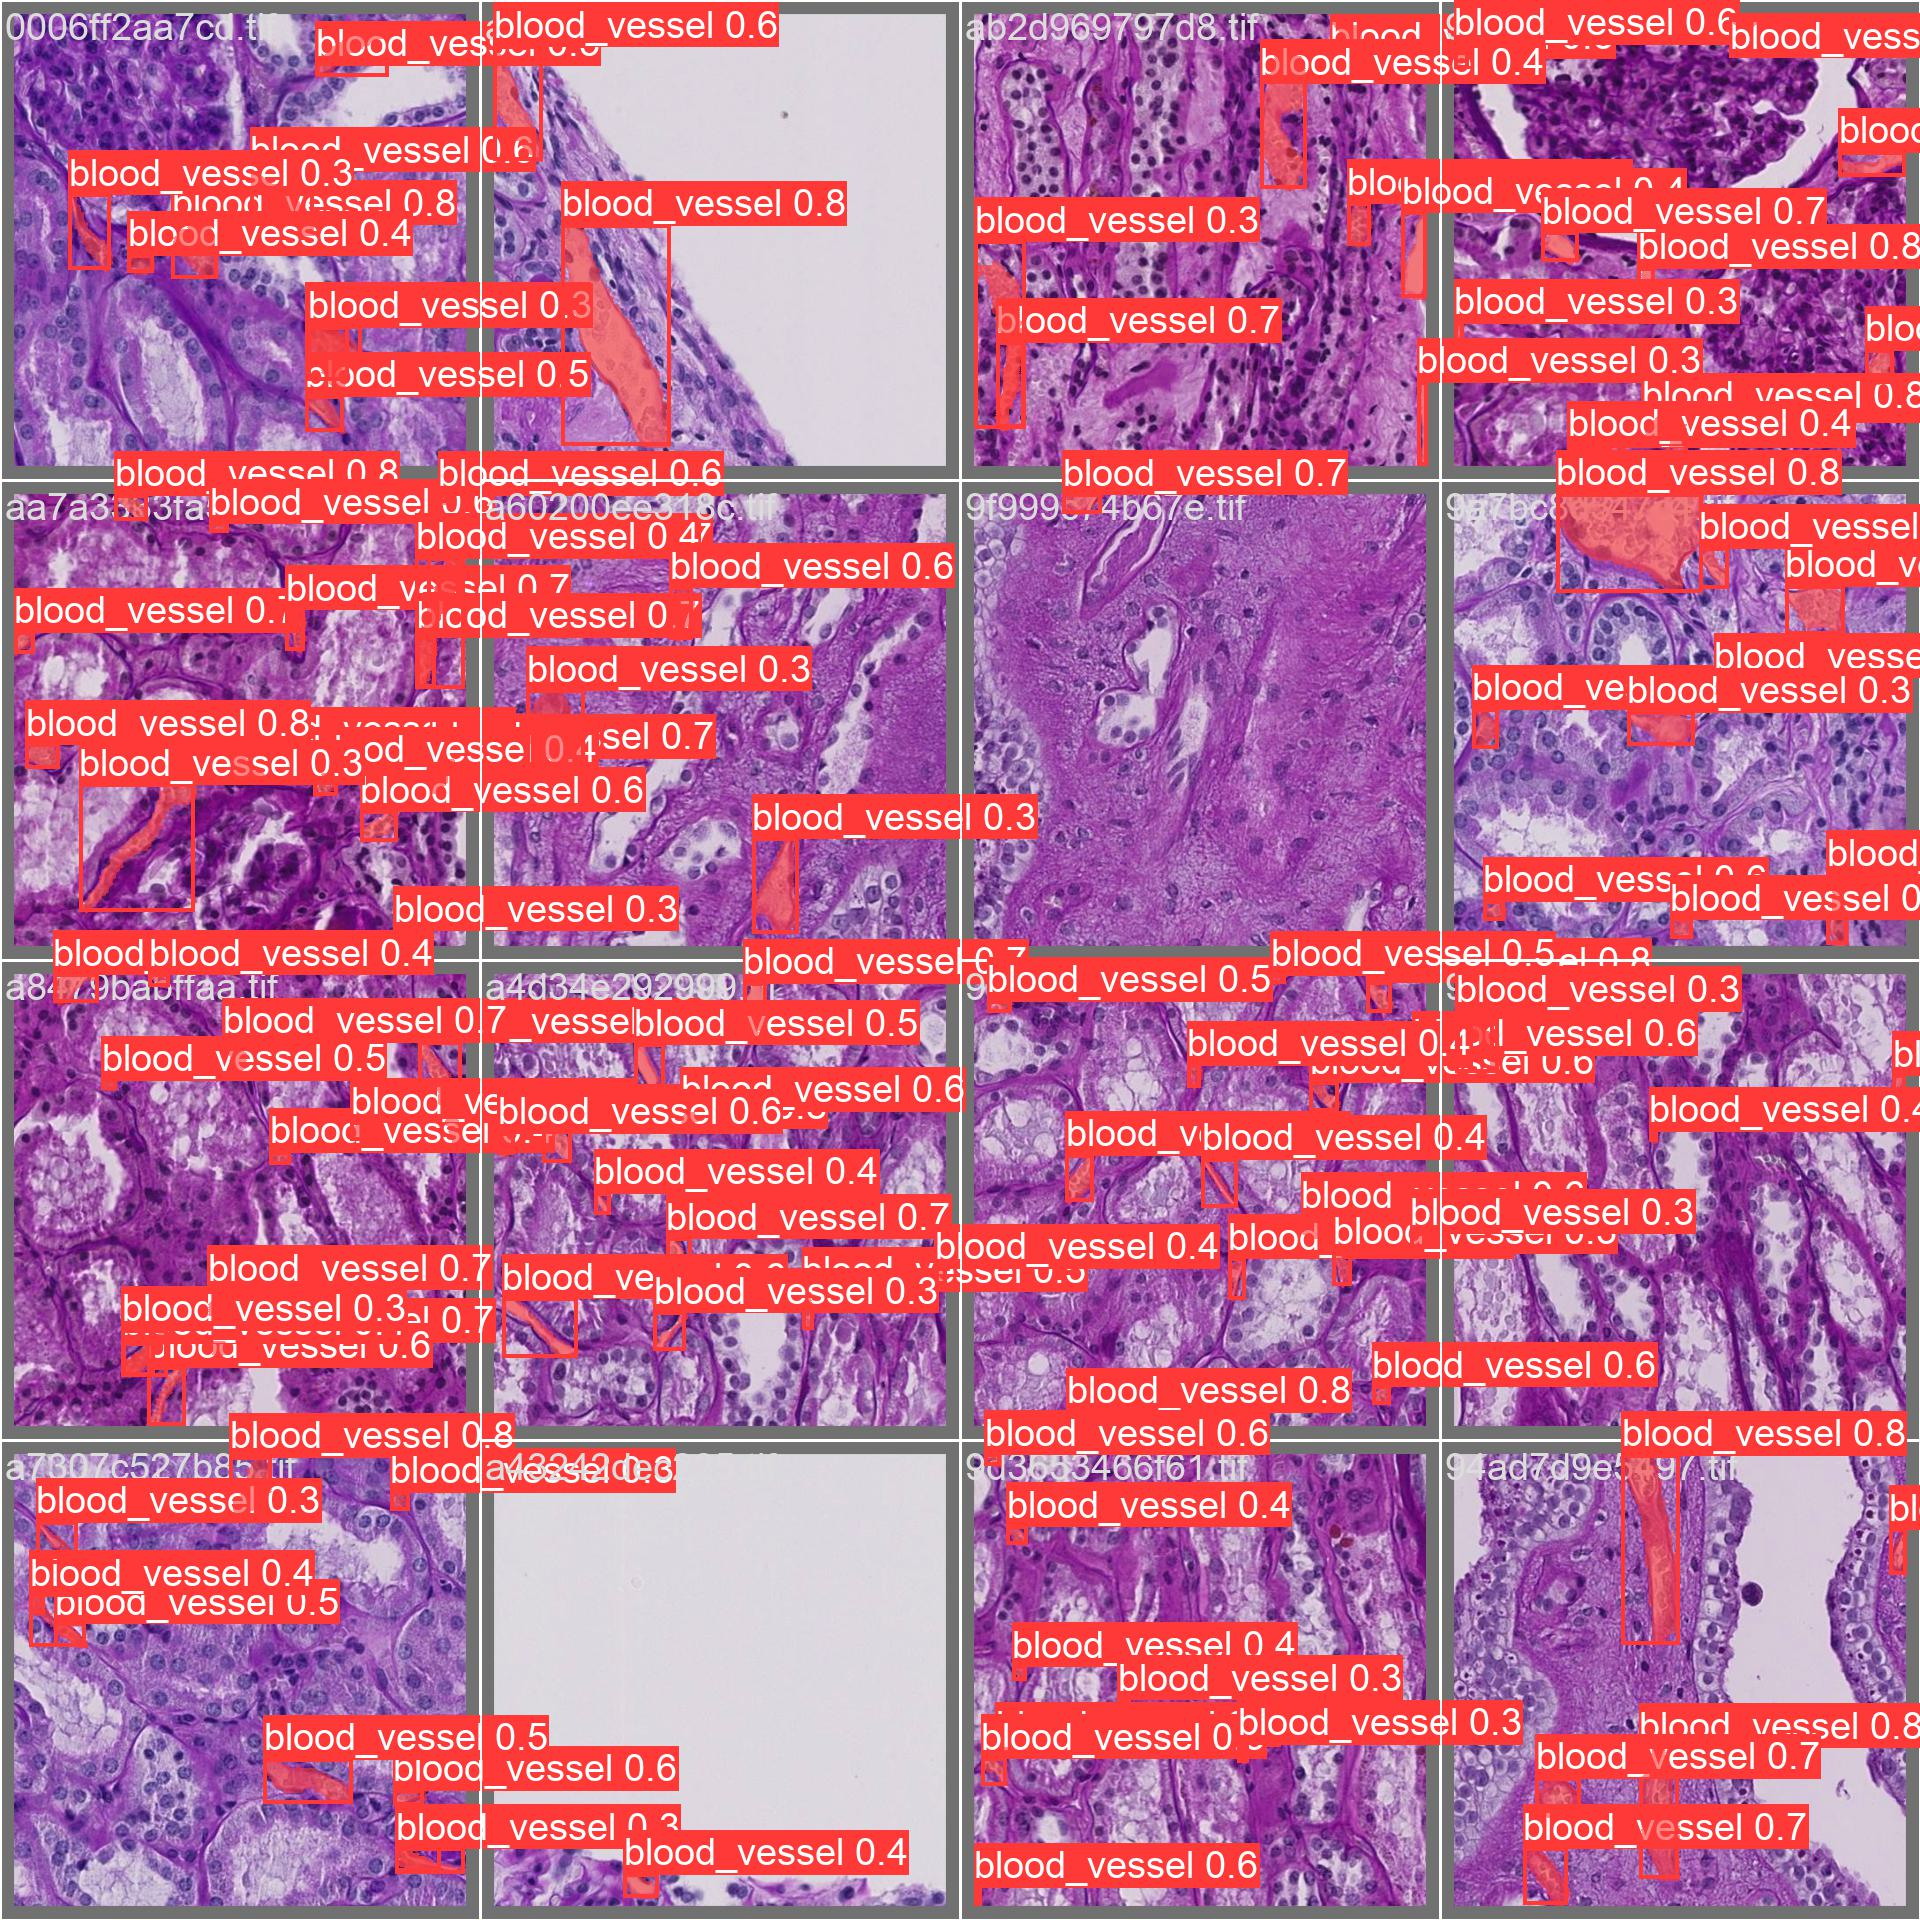

In [16]:
show_image(filename='runs/segment/train/val_batch0_pred.jpg')

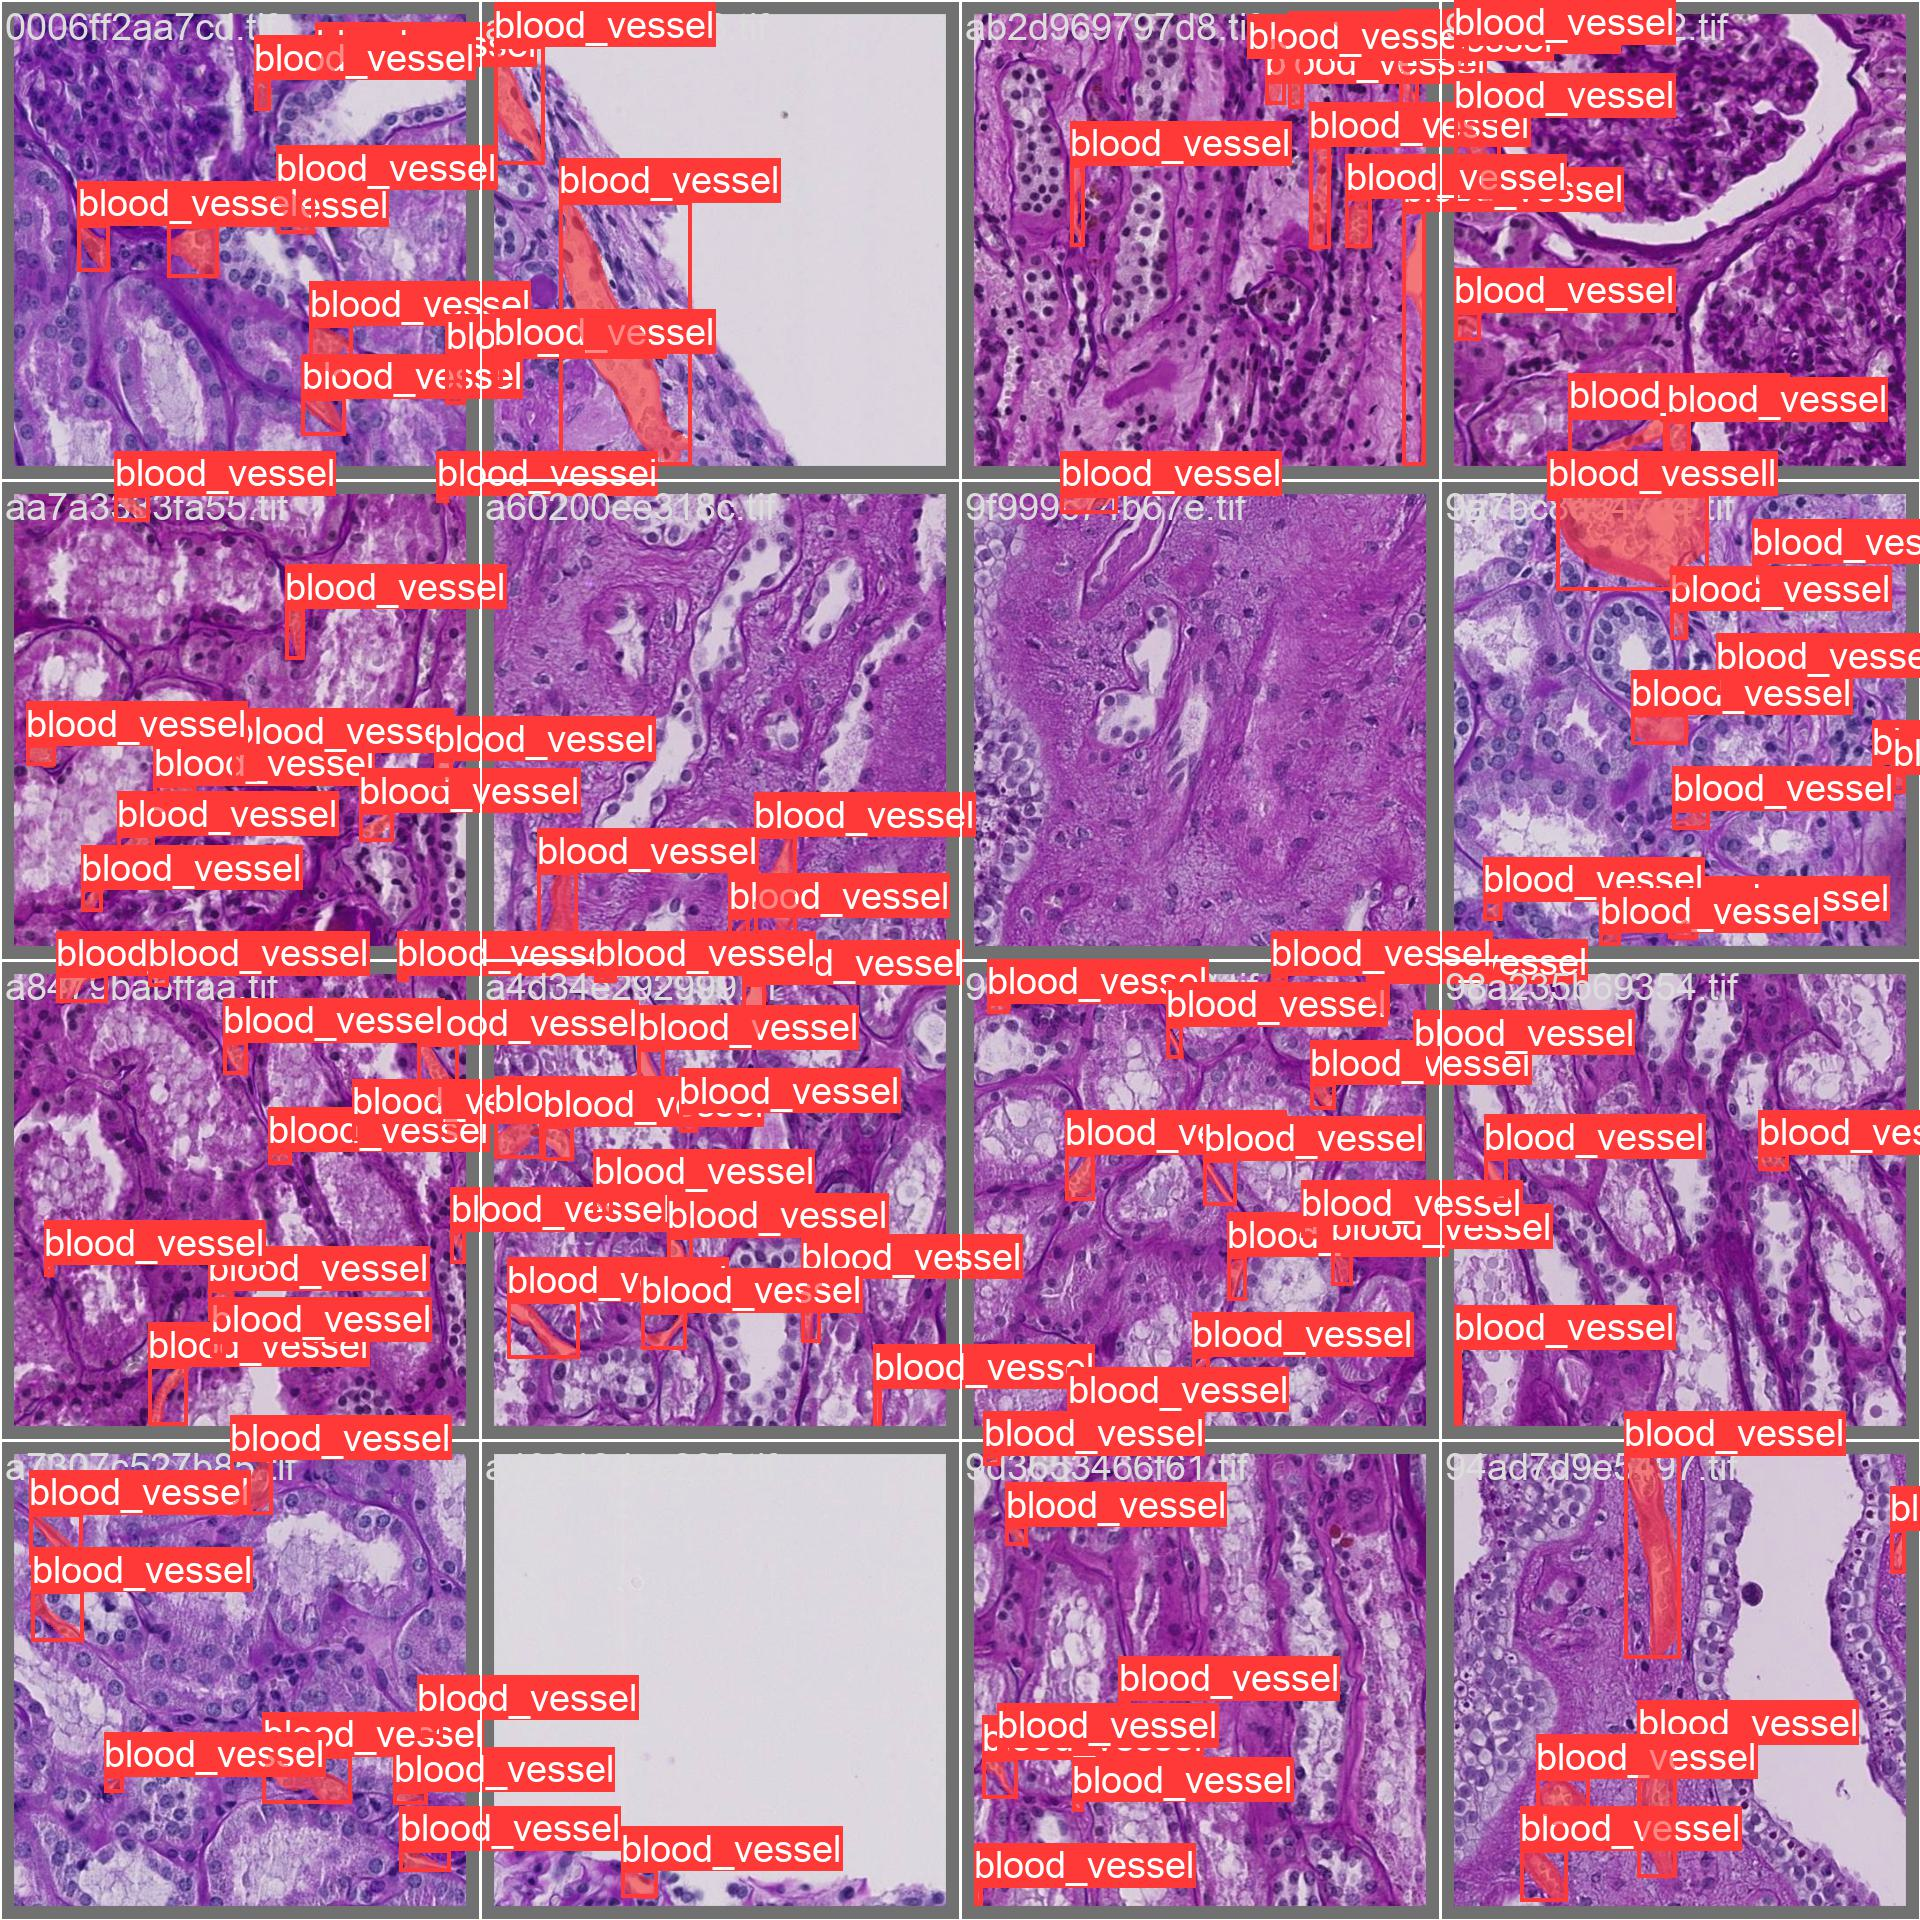

In [17]:
show_image(filename='runs/segment/train/val_batch0_labels.jpg')

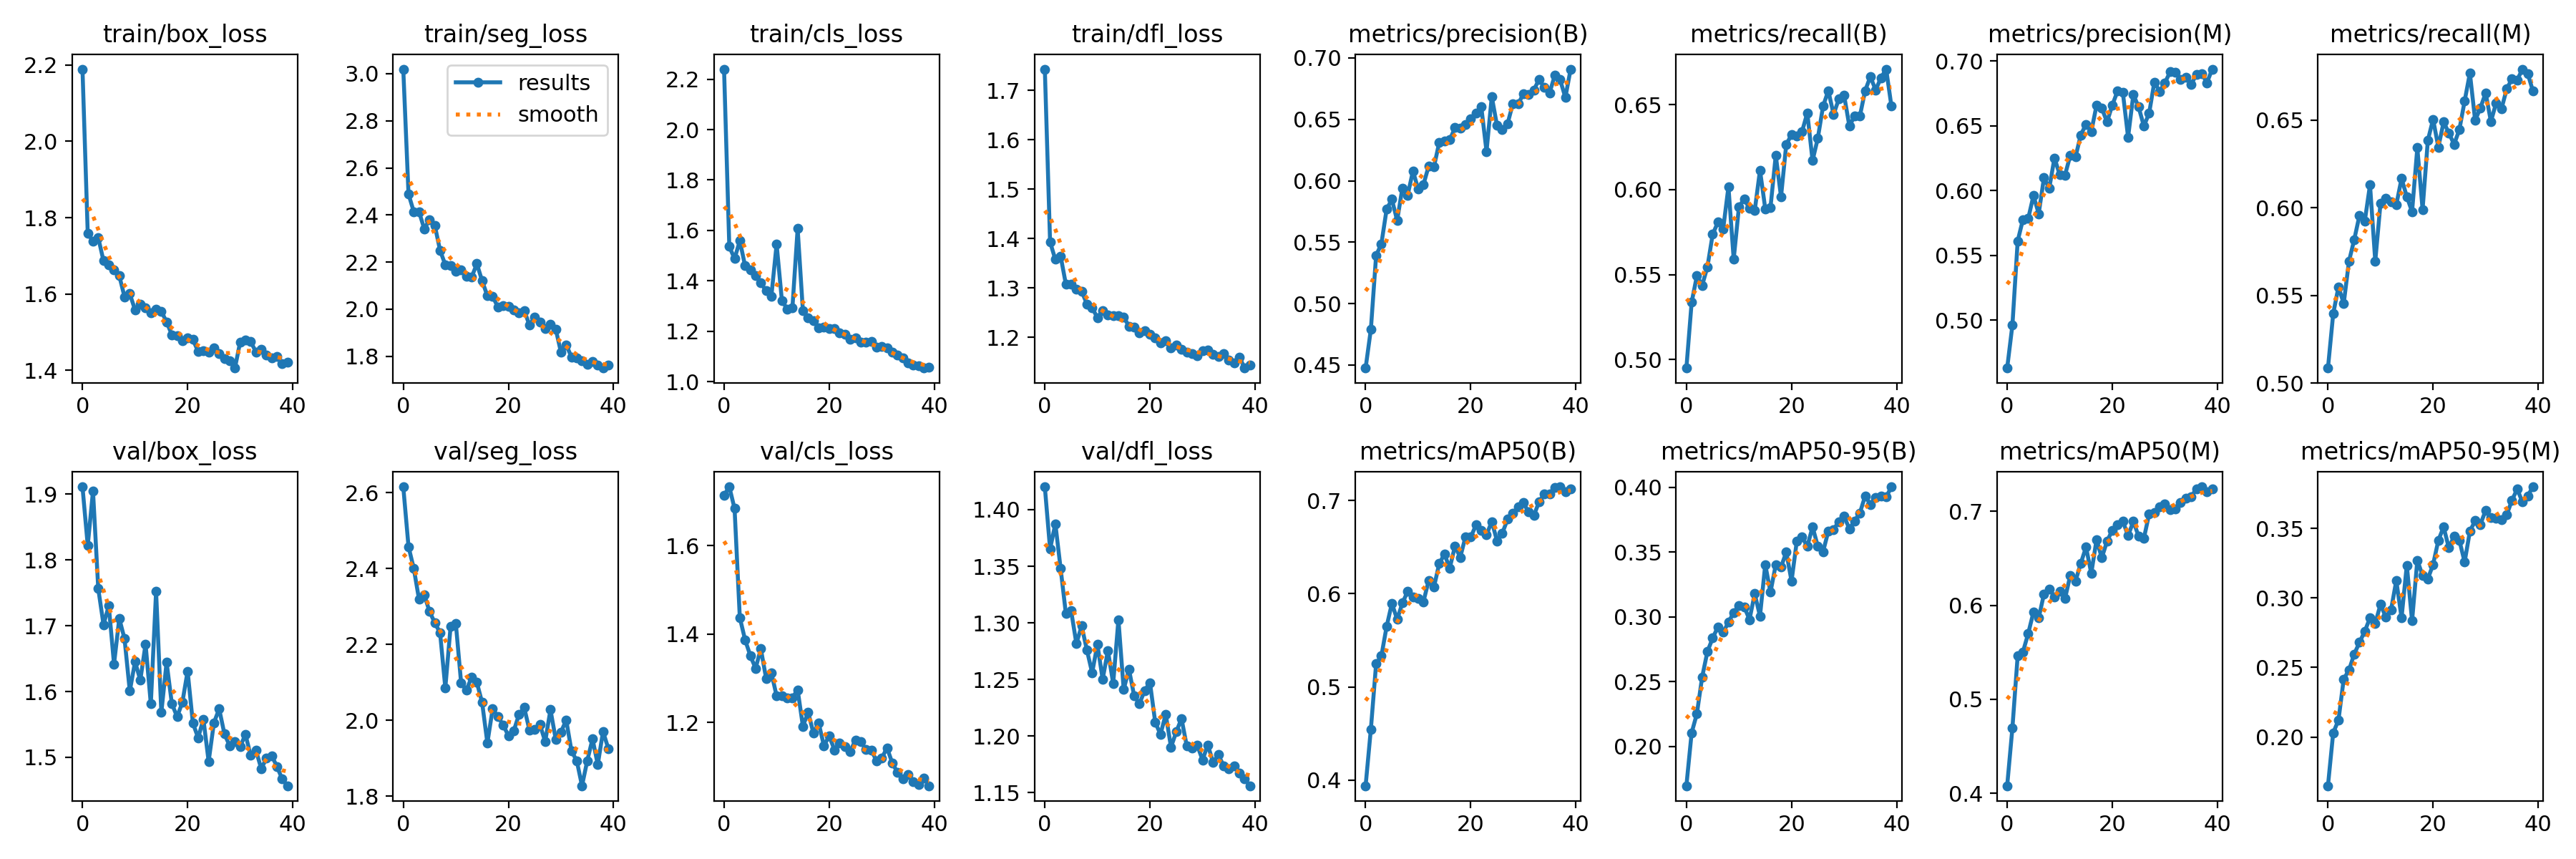

In [18]:
show_image(filename='runs/segment/train/results.png')

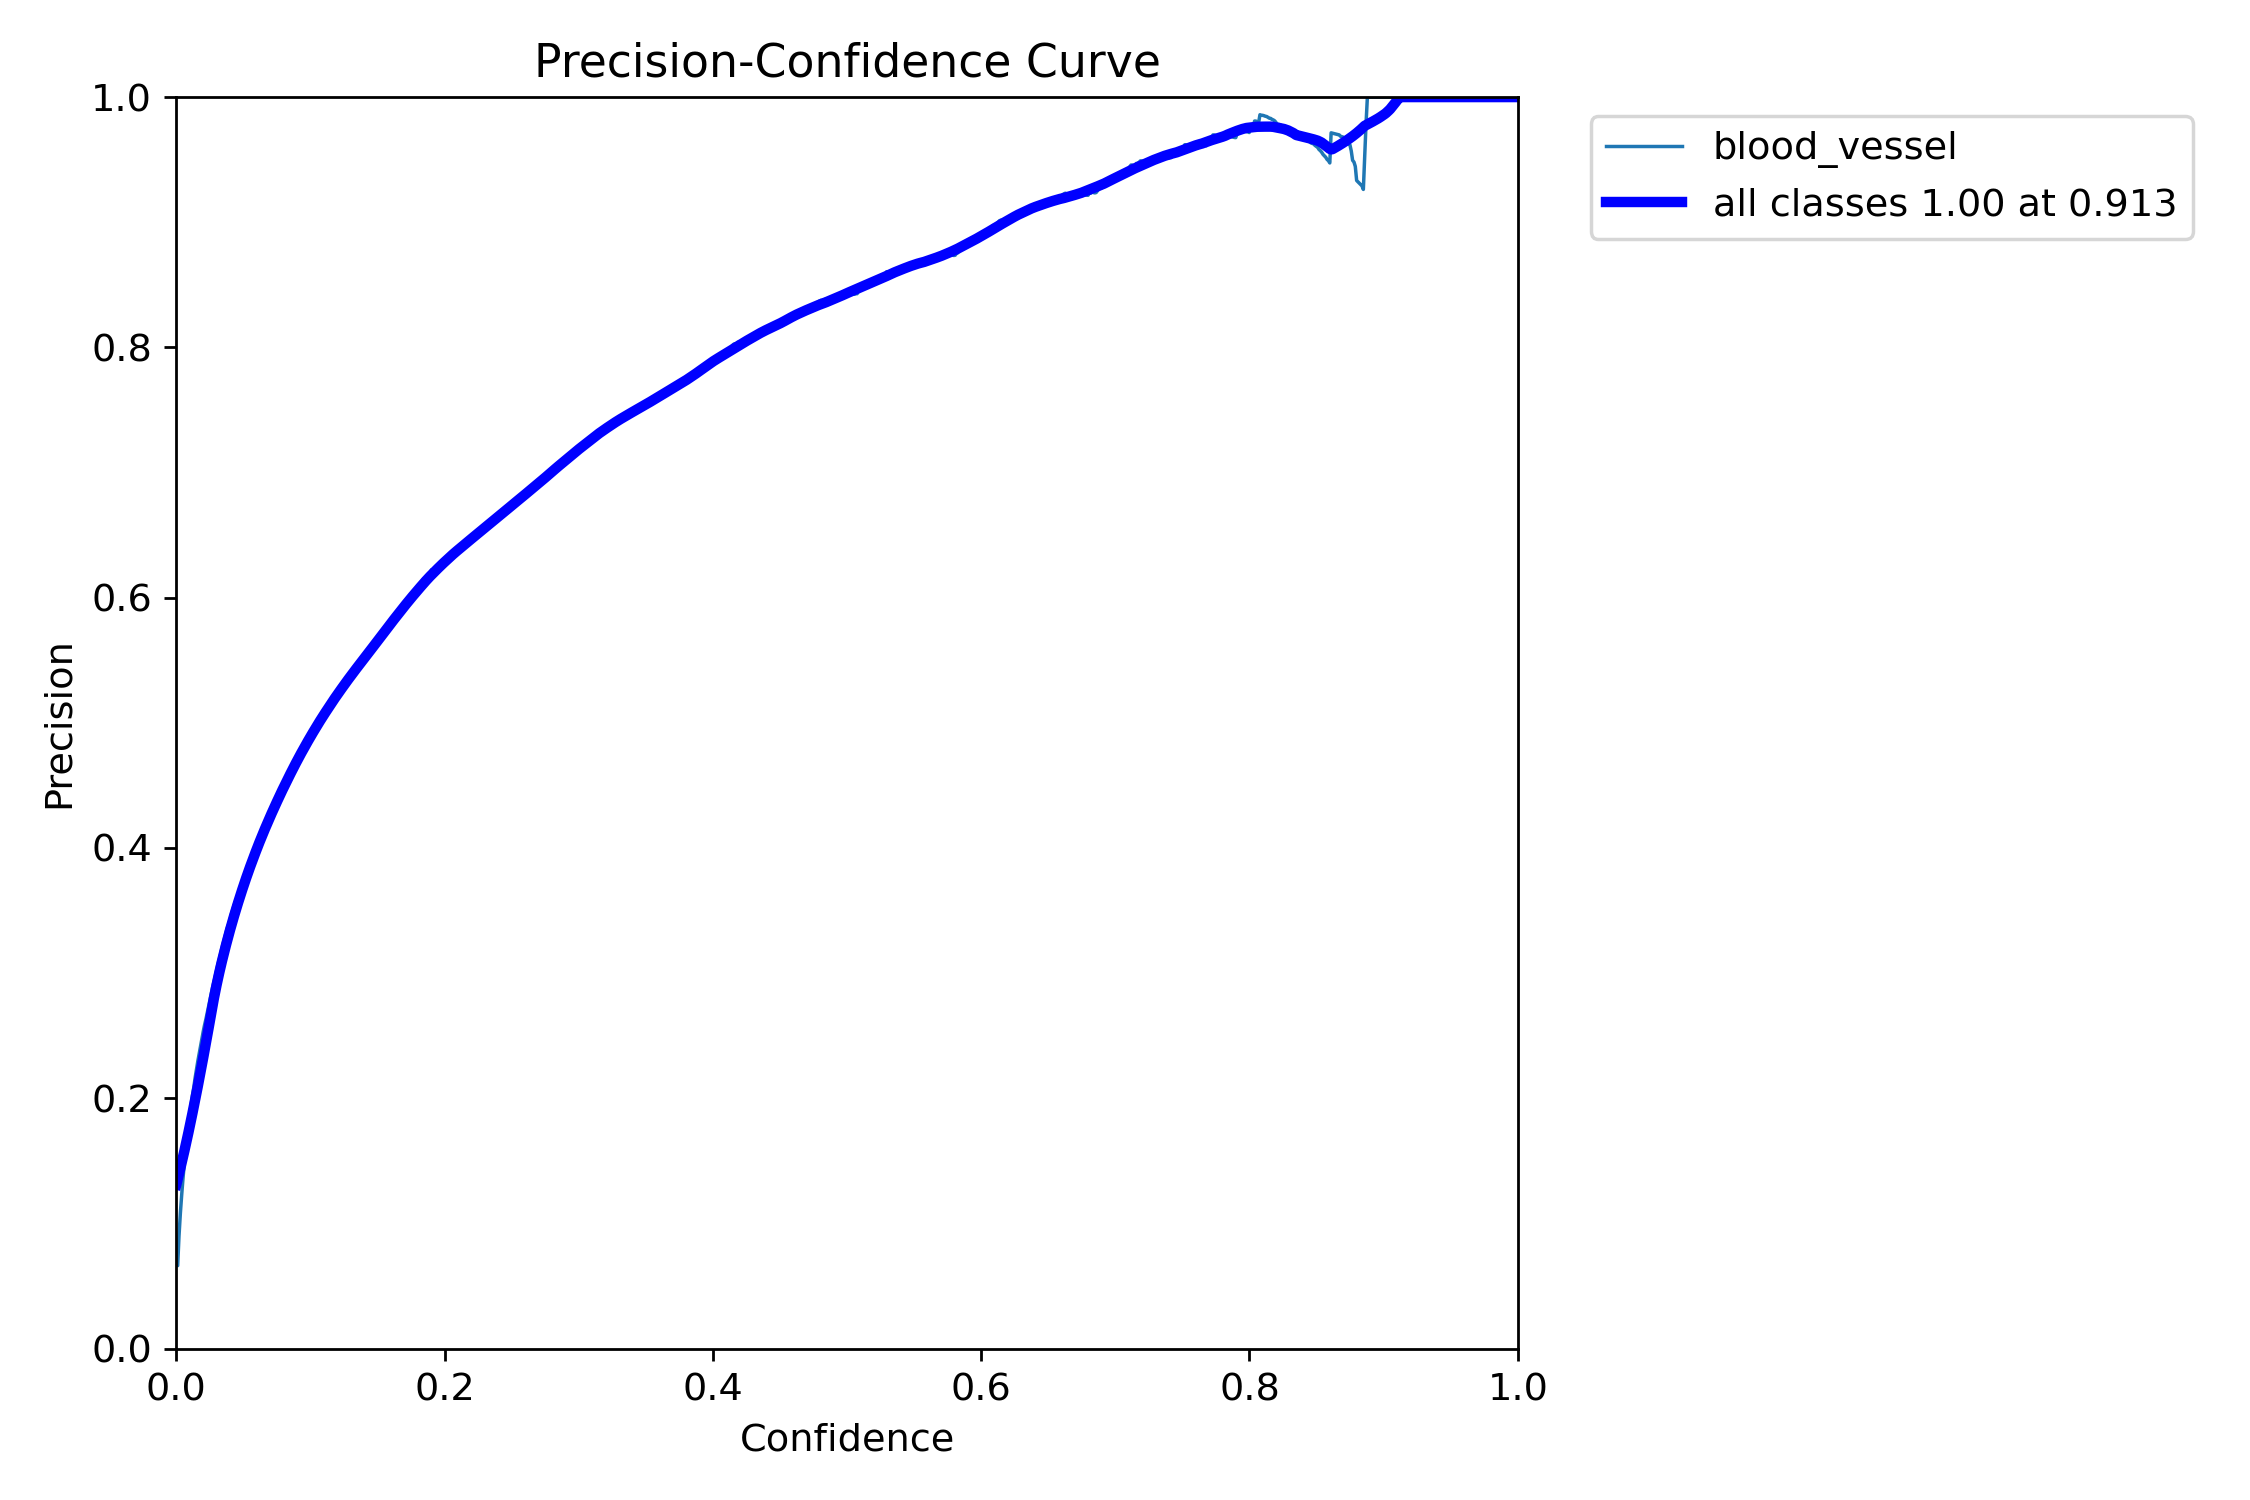

In [19]:
show_image(filename='runs/segment/train/MaskP_curve.png')

In [20]:
trained_model = YOLO('runs/segment/train/weights/best.pt')
results = list(trained_model.predict(test_paths, save=True, conf=0.6))
result = results[0]


0: 512x512 7 blood_vessels, 7.1ms
Speed: 0.5ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/segment/predict


In [21]:
!ls runs/segment/predict

72e40acccadf.tif


In [22]:
image = tiff.imread('runs/segment/predict/72e40acccadf.tif')
plt.imshow(image)

ValueError: <COMPRESSION.LZW: 5> requires the 'imagecodecs' package

: 